In [ ]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#import Loan Data .csv From Prosper from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#https://drive.google.com/file/d/1WGSCbwVvhQe720aoi4aGMKZca-nQXS6E/view?usp=share_link
url='https://drive.google.com/file/d/1WGSCbwVvhQe720aoi4aGMKZca-nQXS6E/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)

df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


#Part 1 - Explore your Data

#Investigation Overview



#####In this investigation, I wanted to look at borrower features that will have the largest effect on the performance of the loan. The main focus was on a few main variables, Loan Status, IncomeRange, DebtToIncomeRatio, Prosper Rating (Alpha), average credit score* and employment status; as it may potentially have the largest effect on the performance of the loan so makes the most sense.

*I averaged CreditScoreRangeLower and CreditScoreRangeUpper to form a single variable.

More on this below:

Variables definition:

1.   **Loan Status** - Whether or not the loan was "Completed", "Current" or past due.
2.   **DebToIncomeRatio** - The debt to income ratio of the borrower at the time the credit profile was pulled. This value is Null if the debt to income ratio is not available. This value is capped at 10.01 (any debt to income ratio larger than 1000% will be returned as 1001%).
3.   **ProsperRating (Alpha)** - The Prosper Rating assigned at the time the listing was created between AA - HR. Applicable for loans originated after July 2009.
4.   **Stated Monthly Income** - Distribution of income for borrower.
5.   **CreditScore** - a new variable that averages the upper and lower range of the credit score.
6.   **EmploymentStatus** - The employment status of the borrower at the time they posted the listing.
7.   **Occupation** -  Occupation of borrower
8.   **Income Range** - Range of income for borrowers

The performance of the loan can be determined by the following features:

8.   **EstimatedReturn** - The estimated return assigned to the listing at the time it was created. Estimated return is the difference between the Estimated Effective Yield and the Estimated Loss Rate. Applicable for loans originated after July 2009. This is on an annual percentage rate (APR).

#Dataset Overview

#####This notebook explores a dataset containing peer-to-peer loan information of 113,937 loans with 80 variables on each loan from Prosper Funding LLC. The variables are a mix of quantitative variables and categorical variables. Along with the dataset, a feature dictionary describing the variables was also provided [here](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0).

You will find that the file (prosperLoanData.csv) isn't uploaded in the repository since we have added it to the google drive then extracted here in this colab notebook for analysis.

In [ ]:
# creating a copy of the original dataset so that i don't affect the original data set. also, used .info() to see key information about the datset.
loan_copy = df.copy()
loan_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

#Data Wrangling

#####Wrangling to clean up data, handle NA & converting variables to ordinal variables

In [ ]:
# na values observed from CreditGrade and EmploymentStatus. replacing these values with "Not available".
na_mask = loan_copy['EmploymentStatus'].isna()
loan_copy.loc[na_mask, 'EmploymentStatus'] = 'Not available'

# repeating the same process for CreditGrade. Replace nan with "Not available". as well as value called "NC", to "No credit".
na_mask_2 = loan_copy['CreditGrade'].isna()
loan_copy.loc[na_mask_2, 'CreditGrade'] = 'Not available'
na_mask_3 = loan_copy['CreditGrade'] == 'NC'
loan_copy.loc[na_mask_3, 'CreditGrade'] = 'No credit'

In [ ]:
# in this step, am converting the variables to ordinal variables
# creating a dictionary for categorisation of ordinal variables
ordinal_var_dict = {'ProsperRating (Alpha)': ['HR','E','D','C','B','A','AA'],
                    'CreditGrade':['Not available','No credit','HR','E','D','C','B','A','AA'],
                   'EmploymentStatus': ['Not available','Not employed','Retired','Other','Employed','Part-time','Self-employed','Full-time'],
                    'LoanStatus':['Cancelled','Chargedoff','Defaulted','Past Due (>120 days)',
                                  'Past Due (91-120 days)','Past Due (61-90 days)',
                                  'Past Due (31-60 days)','Past Due (16-30 days)',
                                  'Past Due (1-15 days)','FinalPaymentInProgress',
                                  'Current','Completed']
       
                   }
# utilising a for loop to reduce repetitive code for conversion of variables to ordinal variables
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, 
                                               categories = ordinal_var_dict[var])
    loan_copy[var] = loan_copy[var].astype(ordered_var)

#Data Exploration

#Univariate Exploration

###Distribution of Estimated Return

####**Observations:**

1.   It appears we have quite a few empty cells since the total number of rows is over 100,000. That had been removed before plotting the distribution of returns.
2.   Most of our loans have an estimated return between 0% and 20%.
3.   Range of returns lie between -18% to 28%.
4.   Largest bin falls right around 12.5%.




In [ ]:
loan_copy.EstimatedReturn.describe()

count    84853.000000
mean         0.096068
std          0.030403
min         -0.182700
25%          0.074080
50%          0.091700
75%          0.116600
max          0.283700
Name: EstimatedReturn, dtype: float64

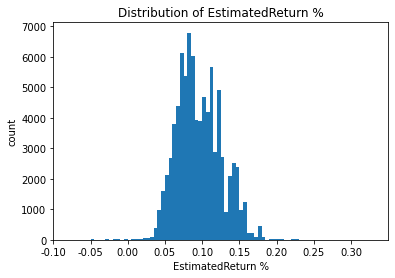

In [ ]:
# drop null rows without an estimated return
loan_copy.EstimatedReturn.dropna(axis = 0, inplace = True)

# distribution of EstimatedReturn %
binsize_apr = 0.005
bins_apr = np.arange(-0.15, loan_copy['EstimatedReturn'].max()+binsize_apr, binsize_apr)

plt.hist(data = loan_copy, x = 'EstimatedReturn', bins = bins_apr)
plt.xlabel('EstimatedReturn %')
plt.xlim((-0.10,0.35))
plt.title('Distribution of EstimatedReturn %')
x_ticks = [-0.10,-0.05,0.00,0.05,0.10,0.15,0.20,0.25,0.30]
x_ticks_names = ['-0.10','-0.05','0.00','0.05','0.10','0.15','0.20','0.25','0.30']
plt.xticks(x_ticks, x_ticks_names)

plt.ylabel('count')

plt.show()

#alternative graph plot v2
#plt.figure(figsize = [8,5])
#sns.distplot(df.EstimatedReturn, kde = False, bins = 200)
#plt.xlim(0, .2)
#plt.xlabel('Estimated Return')
#plt.ylabel('Count')
#plt.title('Distribution of Estimated Returns');

In [ ]:
loan_copy['ProsperRating (Alpha)'].dtypes

CategoricalDtype(categories=['HR', 'E', 'D', 'C', 'B', 'A', 'AA'], ordered=True)

###Distribution of Prosper Rating (Alpha)

####**Observations:**

1.   It appears we have quite a few empty cells since the total number of rows is over 100,000. That had been removed before plotting the distribution of returns.
2.   We are seeing the highest frequency from a C Prosper Rating, making up for 21% of the total number of loans. And the lowest frequency from the HR Prosper Rating loans, (making up for 8.2% of the total number of loans.

In [ ]:
# check na values
loan_copy['ProsperRating (Alpha)'].isna().sum()

29084

In [ ]:
# check value counts
loan_copy['ProsperRating (Alpha)'].value_counts()

C     18345
B     15581
A     14551
D     14274
E      9795
HR     6935
AA     5372
Name: ProsperRating (Alpha), dtype: int64

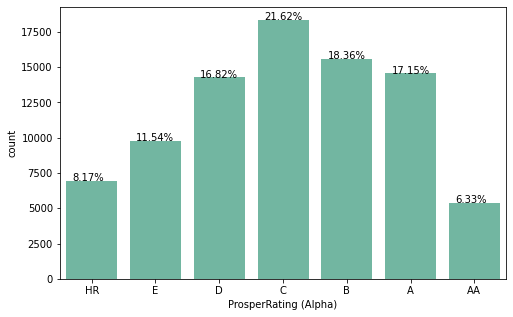

In [ ]:
# plot distribution
plt.figure(figsize = [8, 5])
base_color = sns.color_palette("Set2", 1)


plt.xlabel('ProsperRating (Alpha)')
plt.ylabel('Count')
plot = sns.countplot(data = loan_copy, x = 'ProsperRating (Alpha)', palette = base_color)


rating_counts = loan_copy['ProsperRating (Alpha)'].value_counts()
n_loan = loan_copy.shape[0]

#function to add in percentage labels to bar data
#https://gist.github.com/marco-ostaska/9c786c93a46d7a33cfc6299673863f73 function to print values / percentages in bar chart matplotlib
def barplot_values_percent(ax):
    heightlst = []
    for i in ax.patches:
        heightlst.append(i.get_height())
    total = sum(heightlst)
    
    for i in ax.patches:
        x = i.get_x()+0.10 #adjust the numbers (higher numbers = to the right, lower = to the left)
        height = i.get_height()+2.5 #adjust the numbers (higher numbers = up, lower = down)
        value = ("{0:.2f}".format((i.get_height()/total)*100)+'%')
        
        ax.text(x, height, value, fontsize=10,color='black')

barplot_values_percent(plot)

###Distribution of Loan Status



####**Observations:**

1.   The majority of the loans have been in a healthy state (either "Current" or "Completed"), indicating that the borrowers are either still in the process of paying off the loans or they have successfully paid of the loans.

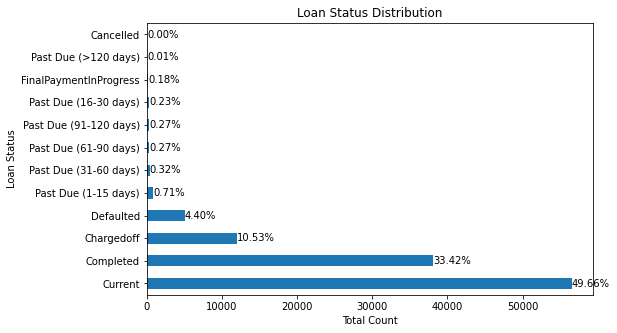

In [ ]:
# plot data
status_counts = loan_copy.LoanStatus.value_counts()
status_order = loan_copy.LoanStatus.value_counts().index

# plot distribution
plt.figure(figsize = [8, 5])
status_counts.plot(kind = 'barh', grid = False)
plt.ylabel('Loan Status')
plt.xlabel('Total Count')
plt.title('Loan Status Distribution');

# plot % labels in descending order
for i in range(status_counts.shape[0]):
    count = status_counts[i]
    pct_string = '{:0.2f}%'.format(100*count/n_loan)
    plt.text(count+10, i, pct_string, va = 'center');

###Which occupations tend to appear the most often / least?



####**Observations:**

1.   Other, Professional, and Computer Programmer appeared the most often in the dataset. Because "Other" and "Professional" tend to be a bit general, we will conclude that Computer Programmer, Executive, and Teacher tend to appear most frequently when it comes to taking out loans.

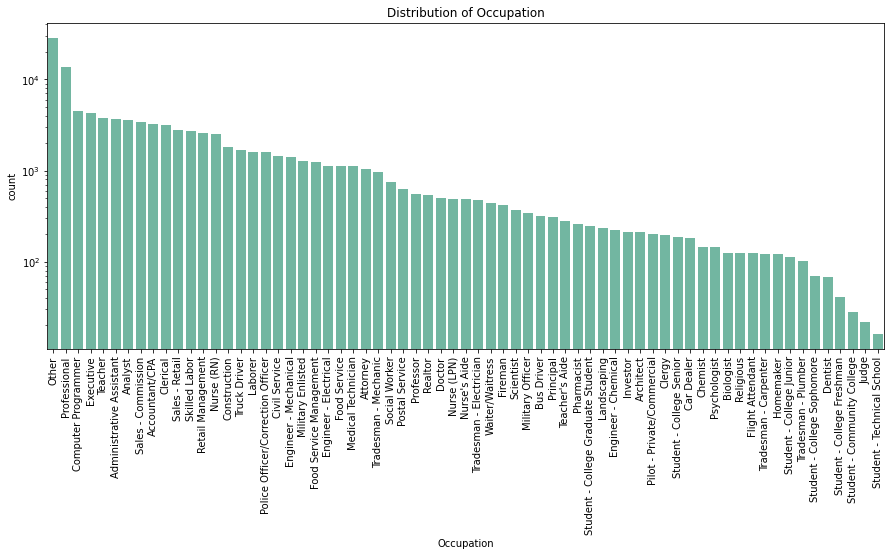

In [ ]:
# plot distribution
occupation_order = loan_copy['Occupation'].value_counts().index
plt.figure(figsize = [15,6])
base_color = sns.color_palette("Set2", 1)

plt.title('Distribution of Occupation')
plt.xlabel('Occupation')
plt.xticks(rotation = 90);
plt.yscale('log')
plt.ylabel('count')
plot = sns.countplot(data = loan_copy, x = 'Occupation', palette = base_color, order = occupation_order)

plot

###What is the distrubition of StatedMonthlyIncome like?



####**Observations:**

1.   From the chart, we can see that the distribution of stated monthly income is right-skewed; with majority of the stated monthly income falling below $30k.

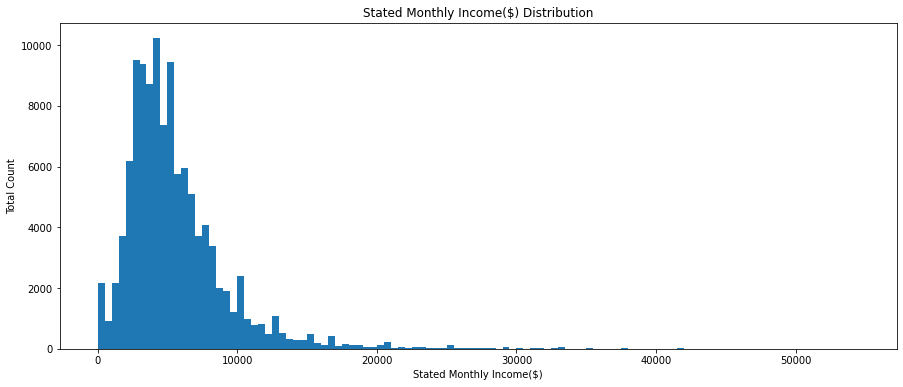

In [ ]:
plt.figure(figsize = [15,6])

income_bins = np.arange(0, 55000, 500)
plt.hist(data = loan_copy, x='StatedMonthlyIncome', bins = income_bins);
plt.xlabel('Stated Monthly Income($)')
plt.ylabel('Total Count')
plt.title('Stated Monthly Income($) Distribution');

###What is the distribution of Loan Amount like?



####**Observations:**

1.   From the chart, there are peaks in frequency at 4000, 15K, and 10K. It seems that these three loan sizes are the most common ones that people took out.

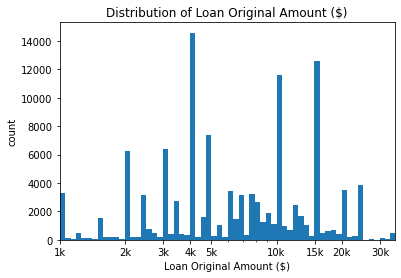

In [ ]:
log_binsize = 0.025
bins_loa = 10 ** np.arange(3, np.log10(loan_copy['LoanOriginalAmount'].max())+log_binsize, log_binsize)
plt.hist(data = loan_copy, x = 'LoanOriginalAmount', bins = bins_loa)
plt.xscale('log')
x_ticks = [1000, 2000, 3000, 4000, 5000, 10000, 15000,20000, 30000]
x_ticks_names = ['1k','2k', '3k', '4k', '5k', '10k','15k', '20k','30k']
plt.xticks(x_ticks, x_ticks_names)
plt.xlim((1000,35000))
plt.xlabel('Loan Original Amount ($)')
plt.ylabel('count')
plt.title('Distribution of Loan Original Amount ($)');


###What is the distribution of Debt To Income Ratio like?


####**Observations:**

1.   Debt-To-Income Ratio is right-skewed when it is less than or equal 1. However, there are about 799 more entries where it is larger than 1; it still wouldn't change that fact that the distribution will be right-skewed, even if we add these data to the graph. 

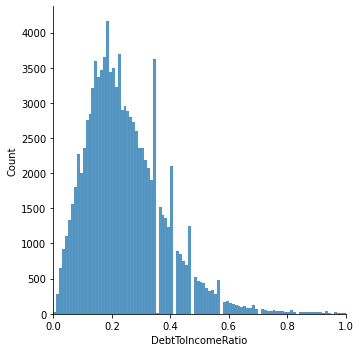

In [ ]:
#distribution where DebtToIncomeRatio <= 1
bin_edges = np.arange(0, loan_copy.DebtToIncomeRatio.max() + 0.01, 0.01)
sns.displot(loan_copy.DebtToIncomeRatio, kde = False, bins = bin_edges)
plt.xlim((0, 1))
plt.grid(False);


###What is the proportion of loan term like?

####**Observations:**

1.   From the donut chart, we see that 77% of all loan terms are 36 months, followed by 60 months at 21.5% and 12 months at 1.4%.



In [ ]:
# set dtype of 'Term' to category
term_order = [12, 36, 60]
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                           categories = term_order)
loan_copy['Term'] = loan_copy['Term'].astype(ordered_var)
loan_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   ListingKey                           113937 non-null  object  
 1   ListingNumber                        113937 non-null  int64   
 2   ListingCreationDate                  113937 non-null  object  
 3   CreditGrade                          113937 non-null  category
 4   Term                                 113937 non-null  category
 5   LoanStatus                           113937 non-null  category
 6   ClosedDate                           55089 non-null   object  
 7   BorrowerAPR                          113912 non-null  float64 
 8   BorrowerRate                         113937 non-null  float64 
 9   LenderYield                          113937 non-null  float64 
 10  EstimatedEffectiveYield              84853 non-null   float64 
 11  

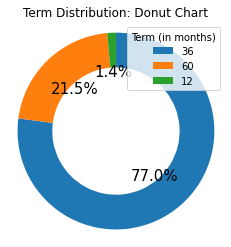

In [ ]:
#donut chart visualisation
sorted_term = pd.DataFrame(loan_copy['Term'].value_counts().reset_index())
labels = sorted_term['index']
textprops = {"fontsize":15}

plt.pie(data = sorted_term, x = 'Term', labels = None, startangle = 90,
        counterclock = False, wedgeprops = {'width': 1.2}, autopct='%.1f%%',radius = 3.4,
       textprops = textprops)

plt.axis('square')
plt.title('Term Distribution: Donut Chart')

plt.legend(labels, title = 'Term (in months)');


###Distribution of Average Credit Score

####**Observations:**

1.   From the distribution chart, we see that the highest frequency for average credit score is 690.



In [ ]:
# create a new variable that averages the upper and lower range of the credit score.
loan_copy['average_credit_score'] = (loan_copy['CreditScoreRangeLower'] + loan_copy['CreditScoreRangeUpper'])/2

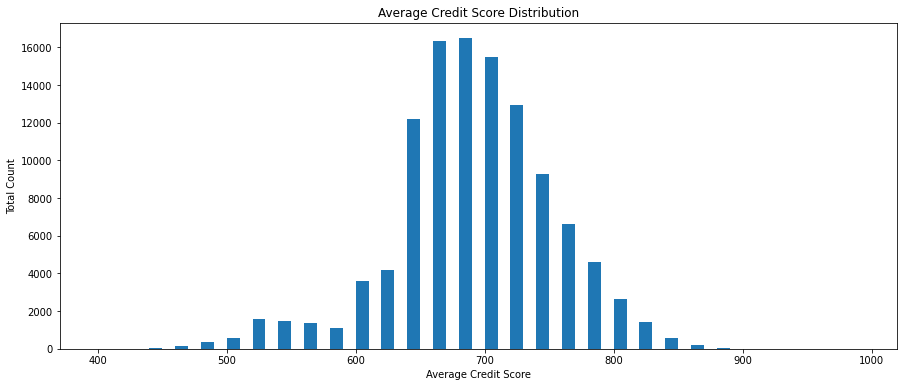

In [ ]:
#plot distribution
plt.figure(figsize = [15,6])

income_bins = np.arange(400, 1000, 10)
plt.hist(data = loan_copy, x='average_credit_score', bins = income_bins);
plt.xlabel('Average Credit Score')
plt.ylabel('Total Count')
plt.title('Average Credit Score Distribution');

###Distribution for range of income

####**Observations:**

1.   The number of borrowers for the 25k to 49k range is the same as the 50k to 74k range. The amount of borrowers in the 75k to 100k range is the same as all borrowers that have an income of over 100k.

In [ ]:
loan_copy.IncomeRange.value_counts()


$25,000-49,999    32192
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
Not displayed      7741
$1-24,999          7274
Not employed        806
$0                  621
Name: IncomeRange, dtype: int64

In [ ]:
# replace not emplyed & not displayed as $0
loan_copy['IncomeRange'].replace(['Not employed', 'Not displayed'], '$0', inplace = True)

# create ordinal categories for income
ordinal_rating = ['$100,000+', '$75,000-99,999', '$50,000-74,999', '$25,000-49,999', '$1-24,999', '$0']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_rating)
loan_copy['IncomeRange'] = loan_copy['IncomeRange'].astype(ordered_var)


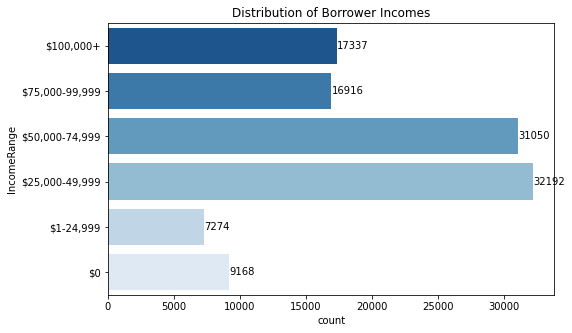

In [ ]:

# bar chart plot
plt.figure(figsize = [8, 5])

loan_copy['IncomeRangeCount'] = loan_copy.IncomeRange.value_counts()
plt.ylabel('Income Range')
plt.xlabel('Count')
plt.title('Distribution of Borrower Incomes');

#plot countplot for incomerange
ax = sns.countplot(data = loan_copy, y = 'IncomeRange', palette = "Blues_r")


# label each bar in horizontal barplot
for p in ax.patches:
 height = p.get_height() # height of each horizontal bar is the same
 width = p.get_width() # width (average number of passengers)
 # adding text to each bar
 ax.text(x = width+3, # x-coordinate position of data label, padded 3 to right of bar
 y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
 s = '{:.0f}'.format(width), # data label, formatted to ignore decimals
 va = 'center') # sets vertical alignment (va) to center

###Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?


I did not perform any transformations because the data looks accurate. Mostly removed NA and renamed data.

###Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?


Were there any unusual distributions?

*   No.

Adjustments made?


*   During the first section of this notebook, had to do some operations on data to convert the variables to ordinal variables.
*   Also, averaged CreditScoreRangeLower and CreditScoreRangeUpper to form a single variable so that we could investigate the potential impact that CreditScore has on loan performance.

#Bivariate Exploration

##Numeric Variables Observation


Before diving into plotting individual charts, will start off with first looking at the pairwise correlation present between features in the data. Will explore numerical variables first to see if any particular pairs have strong correlations.


In [ ]:
#define numeric variables
numeric_vars = [
    'Term', 
    'BorrowerAPR',
    'BorrowerRate',
    'ProsperRating (numeric)',
    'ProsperScore',
    'StatedMonthlyIncome',
    'LoanOriginalAmount',
    'CreditScoreRangeLower',
    'CreditScoreRangeUpper',                
    'average_credit_score',
    'EmploymentStatusDuration',
    'CurrentCreditLines',
    'OpenCreditLines',
    'TotalCreditLinespast7years',
    'OpenRevolvingMonthlyPayment',
    'RevolvingCreditBalance',
    'AvailableBankcardCredit',
    'EstimatedReturn'
               ]

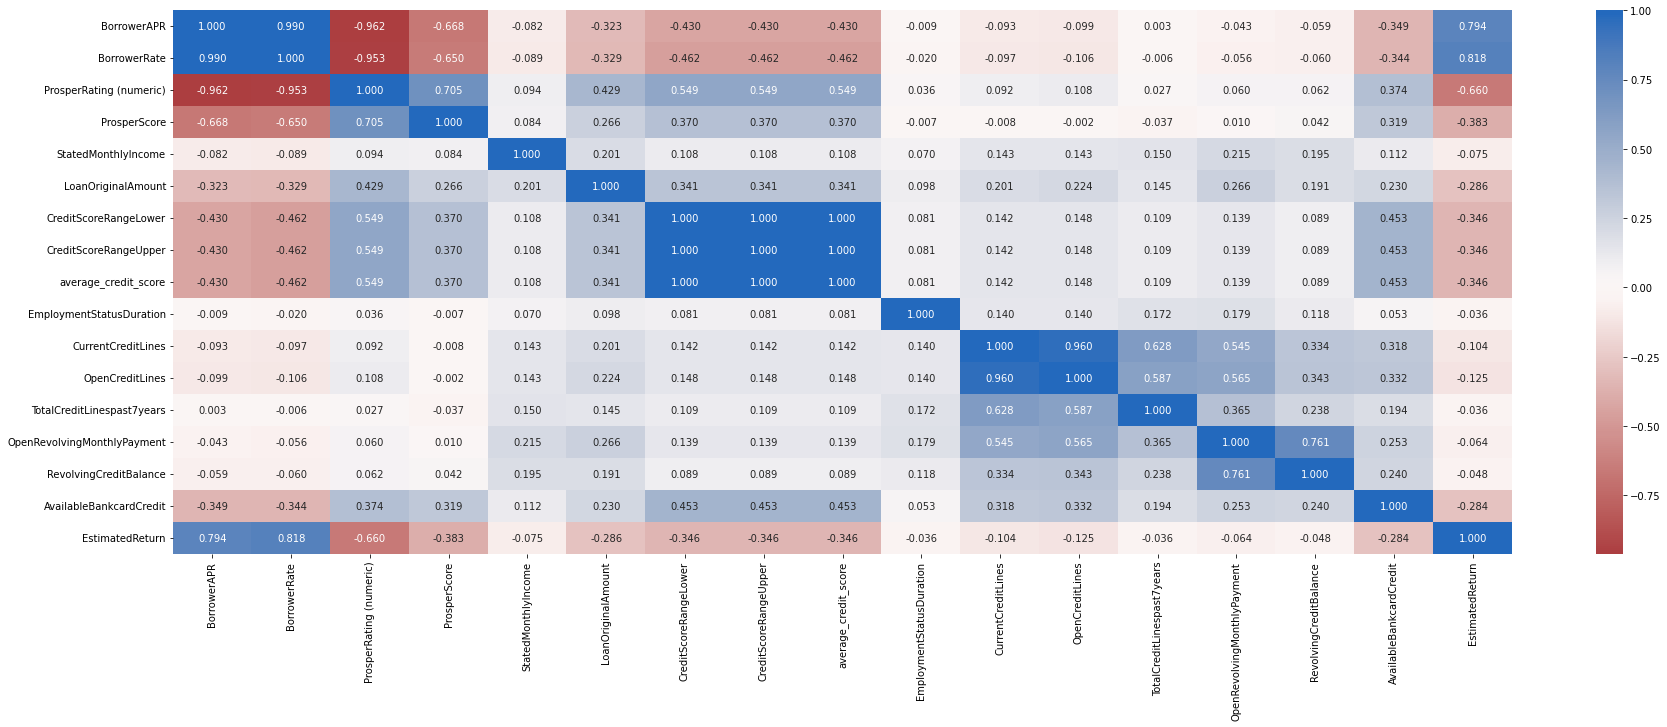

In [ ]:
# correlation plot
plt.figure(figsize = [30,10])
sns.heatmap(loan_copy[numeric_vars].corr(), annot = True, fmt = '.3f',
          cmap = 'vlag_r', center = 0)
plt.show()

####**Observations:**

*   Looking out for an moderate correlations of 0.3<=r<0.7,
    1.   ProsperRating (numeric) (-0.660 r)
    2.   ProsperScore (-0.383 r
    3.   average_credit_score (-0.346 r)
    4.   BorrowerAPR (0.794 r)
    5.   BorrowerRate (0.818 r)



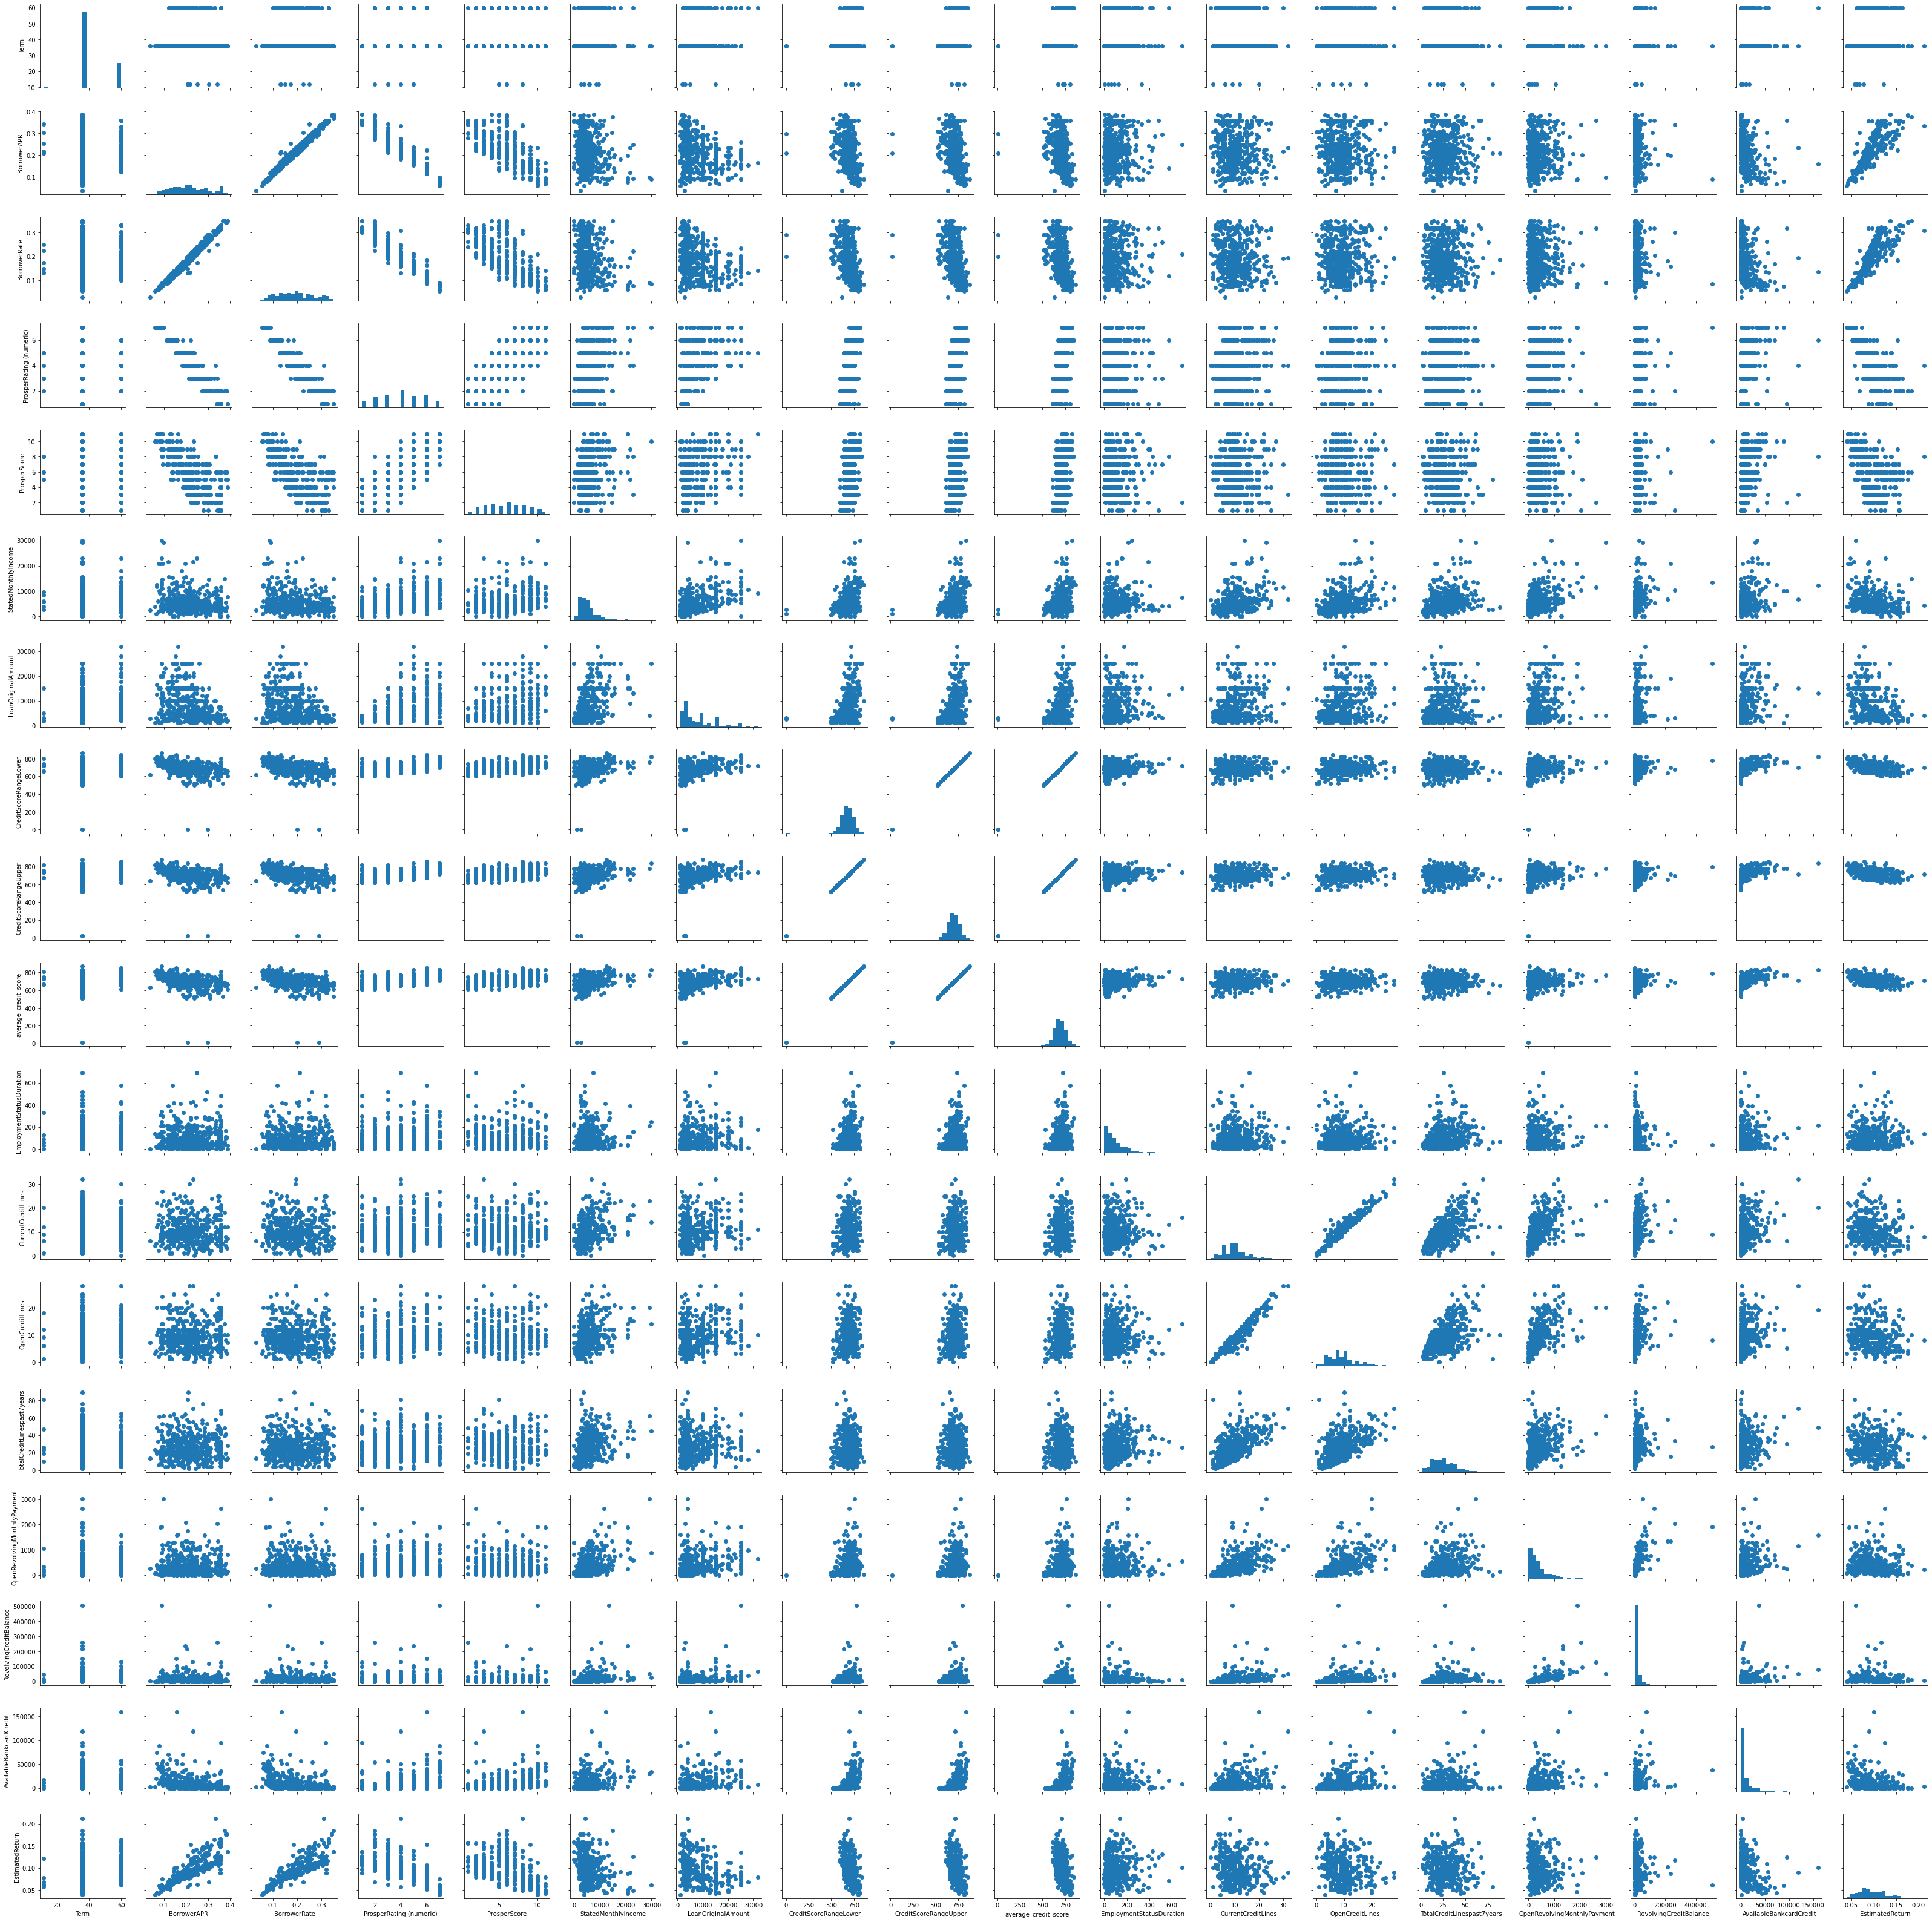

In [ ]:
# plot matrix sampling ~500 loans and plotting it out
samples = np.random.choice(loan_copy.shape[0], 500, replace = False)
loan_samples = loan_copy.loc[samples,:]
g = sns.PairGrid(data = loan_samples, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter)

###Numerical vs. Numerical



Pair 1: ProsperRating (numeric) vs. EstimatedReturn

####Observations

    1.   The higher the ProsperRating (numeric), the lower the concentration of % estimated returns. Higher estimated returns are observed from lower ProsperRating (numeric) score.
    2.   Largest range of returns lie between -5% to 12.5%.

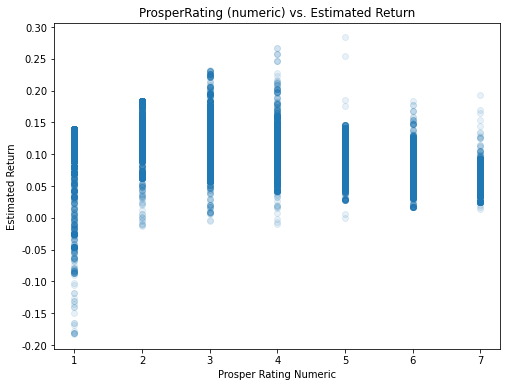

In [ ]:
# Observing the relationship between ProsperRating (numeric) and estimated return as they had the highest negative correlations.
plt.figure(figsize = [8, 6])
plt.scatter(data = loan_copy, x = 'ProsperRating (numeric)', y = 'EstimatedReturn', alpha = 1/10)

x_ticks = [1,2,3,4,5,6,7]
x_tick_name = map(str, x_ticks)
plt.xticks(x_ticks,x_tick_name )
plt.xlabel('Prosper Rating Numeric')
plt.title('ProsperRating (numeric) vs. Estimated Return')

y_ticks = [-0.20,-0.15,-0.10,-0.05,0.00,0.05,0.10,0.15,0.20,0.25,0.30]
y_tick_name = ['-0.20','-0.15','-0.10','-0.05','0.00','0.05','0.10','0.15','0.20','0.25','0.30']
plt.yticks(y_ticks, y_tick_name)
plt.ylabel('Estimated Return')

plt.show()

Pair 2: average_credit_score vs. EstimatedReturn

####Observations:
    1.   we are seeing a pretty clear negative relationship between customers' average credit score and estimated return.



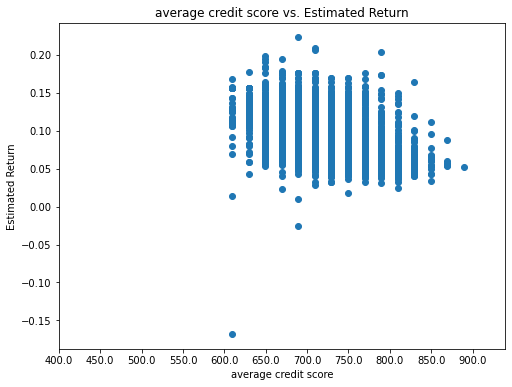

In [ ]:
#observing the relationship between average_credit_score vs EstimatedReturn with sampled data
samples = np.random.choice(loan_copy.shape[0], 5000, replace = False)
loan_sample = loan_copy.loc[samples,:]
plt.figure(figsize = [8, 6])
plt.scatter(data = loan_sample, x = 'average_credit_score', y = 'EstimatedReturn')

binsize = 50
x_ticks = np.arange(400,loan_sample['average_credit_score'].max()+binsize, binsize)
plt.xlim(400,loan_sample['average_credit_score'].max()+binsize)
x_tick_name = map(str, x_ticks)
plt.xticks(x_ticks,x_tick_name )
plt.xlabel('average credit score')

plt.title('average credit score vs. Estimated Return')

y_ticks = [-0.20,-0.15,-0.10,-0.05,0.00,0.05,0.10,0.15,0.20,0.25,0.30]
plt.ylabel('Estimated Return')

plt.show()


Pair 3: BorrowerAPR vs. EstimatedReturn

####Observations:
    1.   One of the highest positive correlated numeric variables at BorrowerRate 0.794 r, graph shows a strong positive relationship between customers' estimated return and borrower APR.



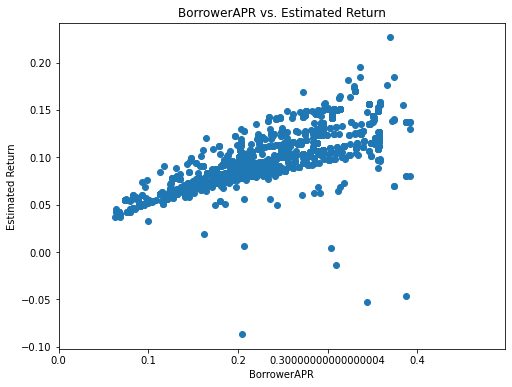

In [ ]:
#observing the relationship between average_credit_score vs EstimatedReturn with sampled data
samples = np.random.choice(loan_copy.shape[0], 2000, replace = False)
loan_sample = loan_copy.loc[samples,:]
plt.figure(figsize = [8, 6])
plt.scatter(data = loan_sample, x = 'BorrowerAPR', y = 'EstimatedReturn')

binsize = .10
x_ticks = np.arange(0,loan_sample['BorrowerAPR'].max()+binsize, binsize)
plt.xlim(0,loan_sample['BorrowerAPR'].max()+binsize)
x_tick_name = map(str, x_ticks)
plt.xticks(x_ticks,x_tick_name )
plt.xlabel('BorrowerAPR')

plt.title('BorrowerAPR vs. Estimated Return')

y_ticks = [-0.20,-0.15,-0.10,-0.05,0.00,0.05,0.10,0.15,0.20,0.25,0.30]
plt.ylabel('Estimated Return')

plt.show()


Pair 4: Borrower Rate vs. EstimatedReturn

####Observations:
    1.   Similar trend to BorrowAPR, One of the highest positive correlated numeric variables at 0.818 r, graph shows a strong positive relationship between customers' estimated return and borrower rate.



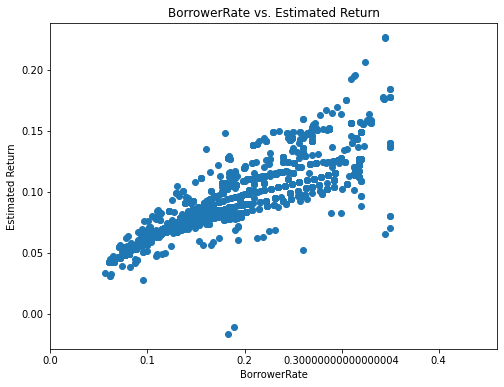

In [ ]:
#observing the relationship between average_credit_score vs EstimatedReturn with sampled data
samples = np.random.choice(loan_copy.shape[0], 2000, replace = False)
loan_sample = loan_copy.loc[samples,:]
plt.figure(figsize = [8, 6])
plt.scatter(data = loan_sample, x = 'BorrowerRate', y = 'EstimatedReturn')

binsize = .10
x_ticks = np.arange(0,loan_sample['BorrowerRate'].max()+binsize, binsize)
plt.xlim(0,loan_sample['BorrowerRate'].max()+binsize)
x_tick_name = map(str, x_ticks)
plt.xticks(x_ticks,x_tick_name )
plt.xlabel('BorrowerRate')

plt.title('BorrowerRate vs. Estimated Return')

y_ticks = [-0.20,-0.15,-0.10,-0.05,0.00,0.05,0.10,0.15,0.20,0.25,0.30]
plt.ylabel('Estimated Return')

plt.show()


##Numeric Variables vs. Categorical Variables (Quantitative vs. Qualitative)

Apart from plotting out numeric variables, will  -mainly plot numeric features against categorical features. to see how estimated return correlate to the rest of the categorical variables.

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid p

<Figure size 720x720 with 0 Axes>

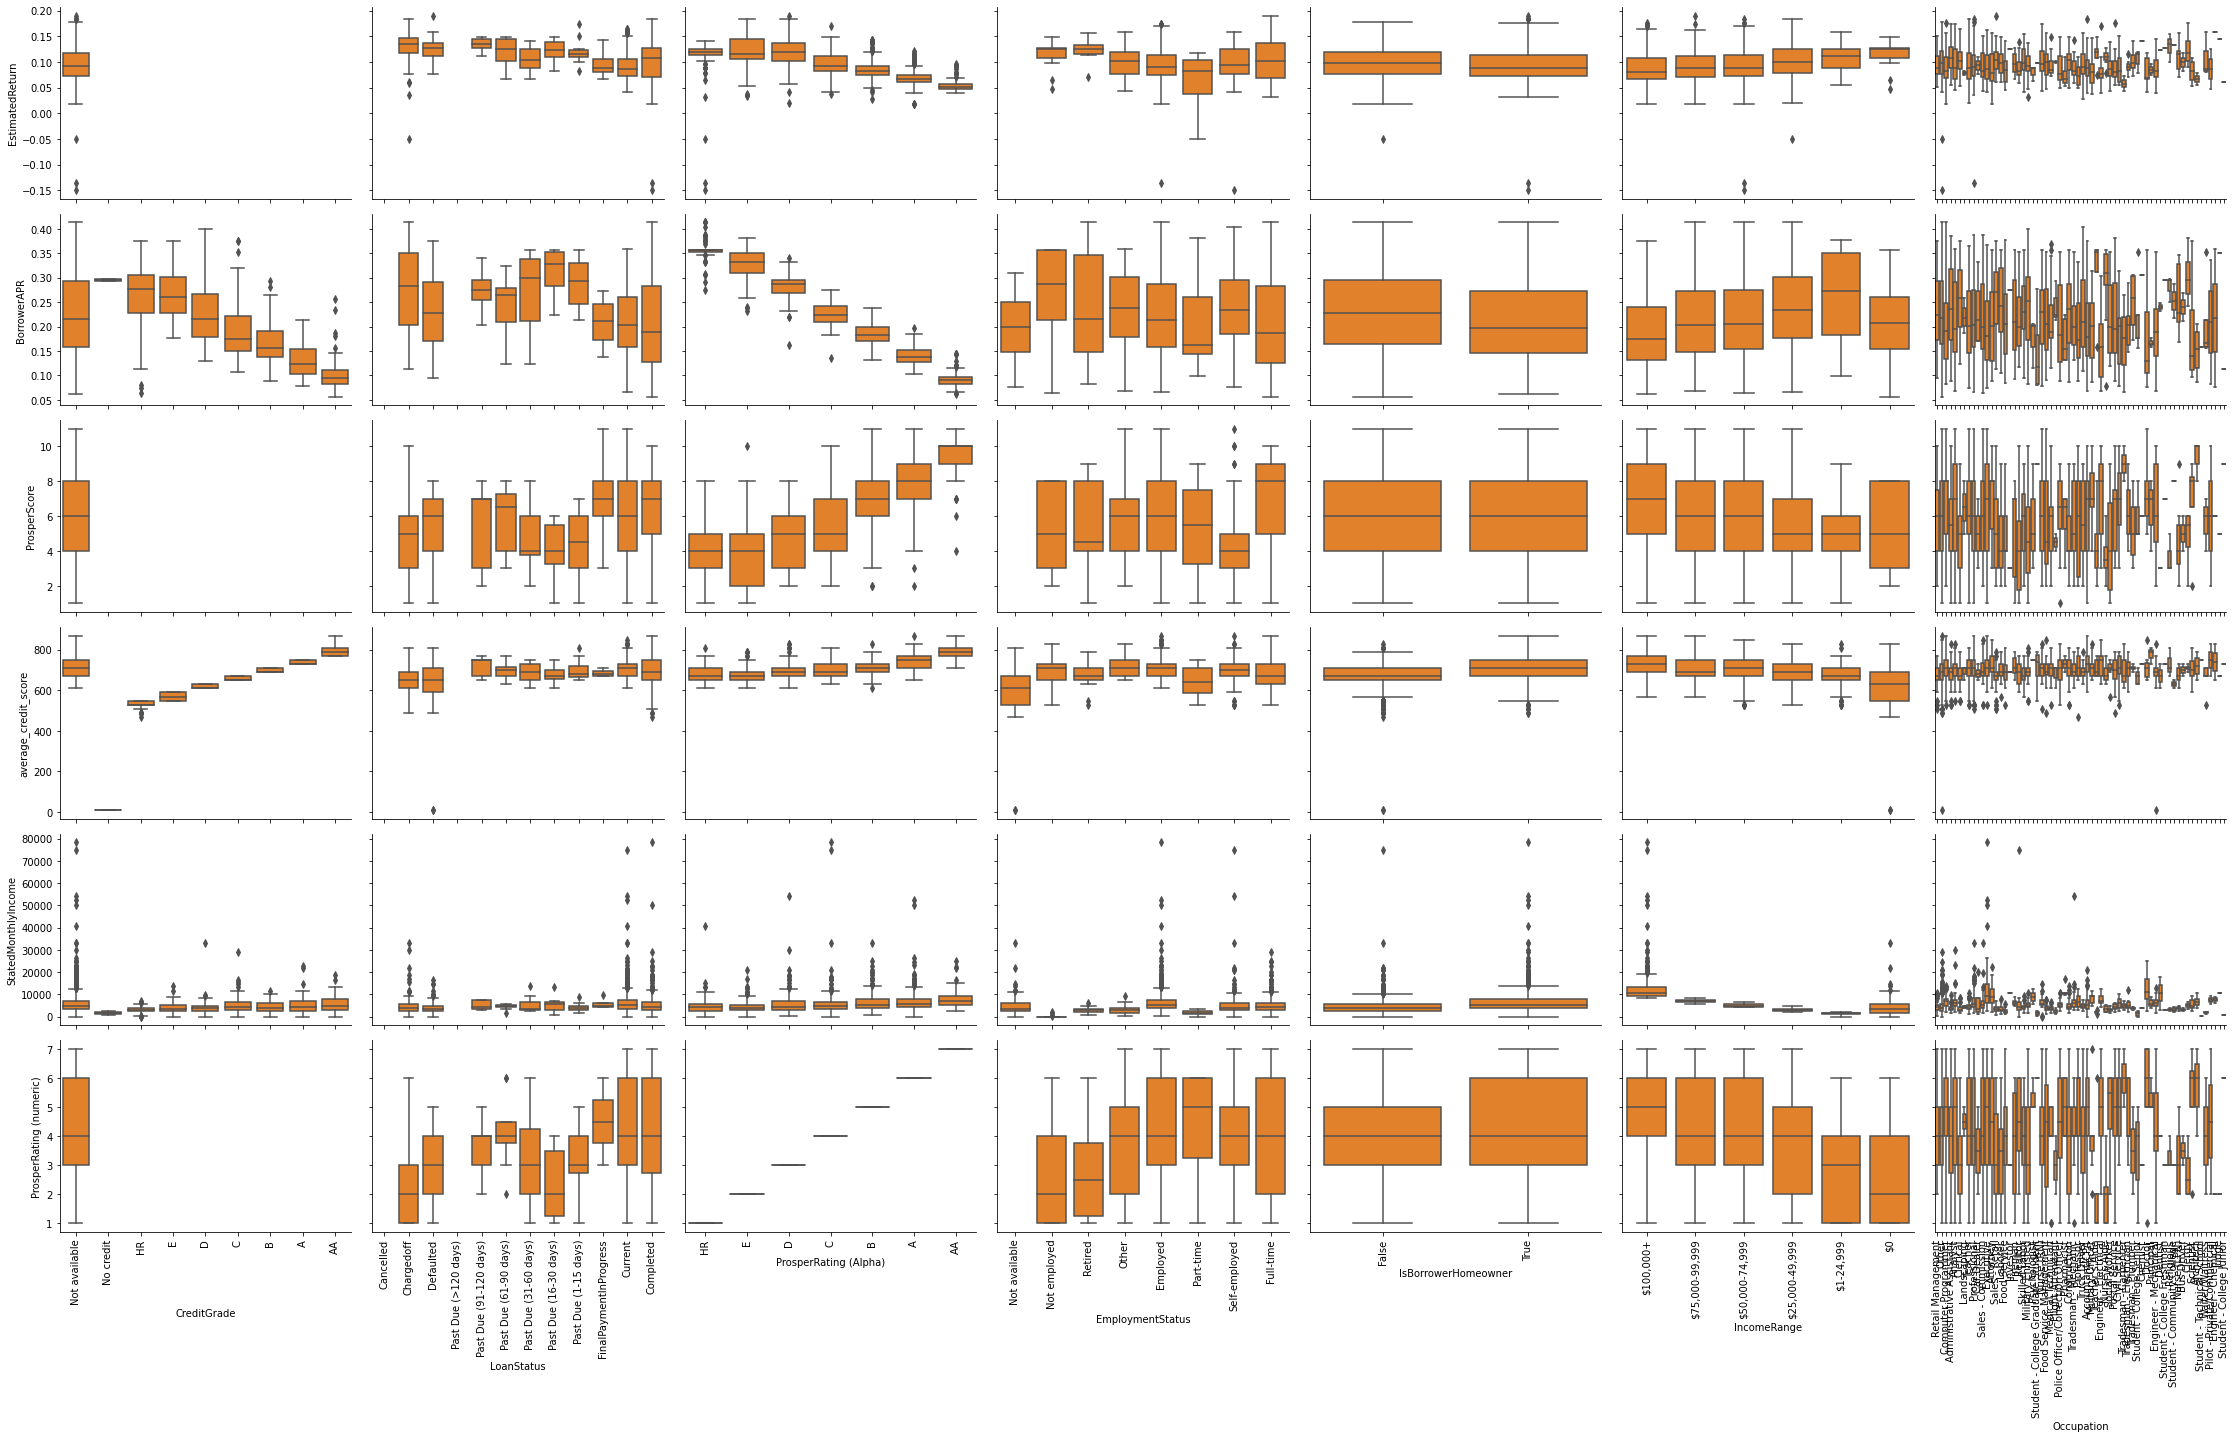

In [ ]:
#now we are going to plot a matrix of numeric features against categorical features.
samples = np.random.choice(loan_copy.shape[0], 2000, replace = False)
loan_sample = loan_copy.loc[samples,:]
def boxgrid(x, y, **kwargs):
    default_color = sns.color_palette()[1]
    sns.boxplot(x, y, color = default_color)
    plt.xticks(rotation = 90)
plt.figure(figsize = [10,10])
categoric_vars = ['CreditGrade',
                  'LoanStatus',
                  'ProsperRating (Alpha)',
                  'EmploymentStatus',
                'IsBorrowerHomeowner',
                'IncomeRange',
                'Occupation'
                 ]

g = sns.PairGrid(data = loan_sample, y_vars = ['EstimatedReturn', 'BorrowerAPR', 'ProsperScore','average_credit_score', 'StatedMonthlyIncome','ProsperRating (numeric)'], x_vars = categoric_vars, size = 3, aspect =1.5)
g.map(boxgrid)
plt.show()

###Numerical vs. Categorical

Pair 1: EstimatedReturn vs. Income Range OR ProsperRating (Alpha)

####Observations:
    1.   By comparing the two graphs, we tend to see more outliers in the case of Income Range vs. Prosper Rating. 
    2.   Generally, seeing higher Estimated Return with higher income ranges. But once income = $0, Estimated Return is highest.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


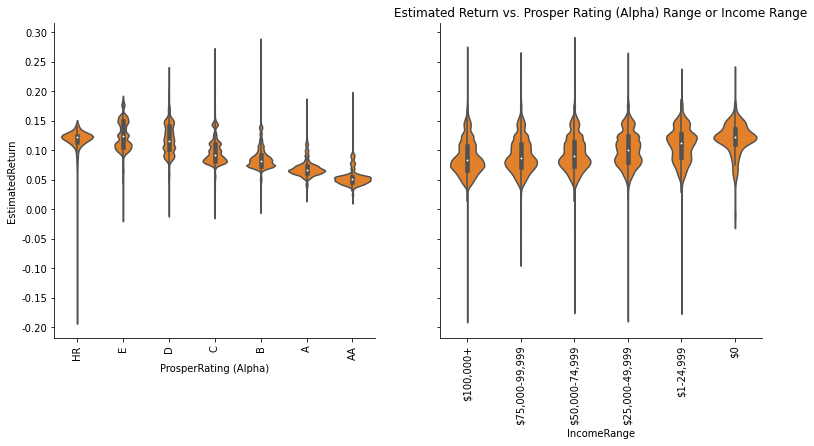

In [ ]:
def boxgrid(x,y,**kwargs):
    default_color = sns.color_palette()[1]
    sns.violinplot(x, y, color = default_color)
    y_ticks = [-0.20,-0.15,-0.10,-0.05,0.00,0.05,0.10,0.15,0.20,0.25,0.30]
    y_ticks_names = ['-0.20','-0.15','-0.10','-0.05','0.00','0.05','0.10','0.15','0.20','0.25','0.30']
    plt.yticks(y_ticks, y_ticks_names)
    plt.xticks(rotation = 90)
    plt.ylabel('Estimated Return')

g = sns.PairGrid(data = loan_copy, y_vars = 'EstimatedReturn', x_vars = ['ProsperRating (Alpha)','IncomeRange'])
plt.title('Estimated Return vs. Prosper Rating (Alpha) Range or Income Range')
g.fig.set_size_inches(12,6)
g.map(boxgrid)
plt.show()

Pair 2: EstimatedReturn vs. Employment Status

####Observations:
    1.   People who are not employed would receive the highest estimated return at ~11.9% vs. employed borrowers' 9.5%.
    2.   This finding co-incides with the finding above where if your income is $0 income range, your Estimated Return will be the highest.

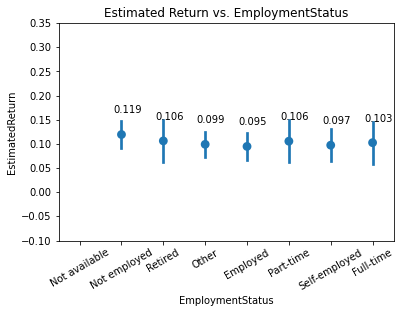

In [ ]:
sns.pointplot(data = loan_copy, x = 'EmploymentStatus', y = 'EstimatedReturn',
          ci = 'sd', linestyles = '')


plt.xticks(rotation = 30)
plt.ylabel('EstimatedReturn')
plt.ylim((-0.100,0.35))
mean_calc = loan_copy.groupby('EmploymentStatus')['EstimatedReturn'].mean()
type_counts = loan_copy['EmploymentStatus'].value_counts()
plt.title('Estimated Return vs. EmploymentStatus')
for i in range(type_counts.shape[0]):
    mean_VClass = mean_calc[i]
    mean_string = '{:0.3f}'.format(mean_VClass)
    plt.text(i-0.2, mean_VClass+0.05, mean_string, va = 'center')


###Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?



**Estimated Return has a positive co relation to income ranges**

Surprisingly, the higher your income range, the higher the estimated returns are. However, this changes when the borrower has income of $0 which is equivalent to being unemployed. 

This finding coincides with the last pointplot plotted where the highest returns come from people who are “Unemployed”

**Estimated Return and Prosper Rating have a strong negative correlation**

The higher the ProsperRating (numeric) the lower the concentration of % estimated returns. Higher estimated returns are observed from lower ProsperRating (numeric) score.

**Estimated Return and customer's credit score**

We are seeing a pretty clear negative relationship between customers' average credit score and estimated return. This makes sense and the reverse is true. The higher the credit score, the lower estimated return.

###Did you observe any interesting relationships between the other features (not the main features of interest?





1.   Prosper rating and average credit score have a moderate positive correlation of 0.549. The higher the credit score, the higher the prosper rating.
2.   The relationship between Employment Status Duration and the rest of the numeric variables had little to no correlation; especially to estimated return or borrower APR. Meaning job stability has nothing to do with credit score / ability to repay.




#Multivariate Exploration

In this section, I want to explore how different variables can affect the Estimated Return's relationship with another variable; mainly relationship between Prosper Rating (Alpha) and Estimated Return & other variables. A couple of variables of interest include:


1.   Term
2.   Employment Status
3.   IncomeRange
4.   Average Credit Score



Pair 1: EstimatedReturn vs. Terms & Prosper Ratings

####Observations:
    1.   For each individual term over every rating, the APR decreases as the rating increases.
    2.   The longer the term of the loan, the higher the estimated return is.

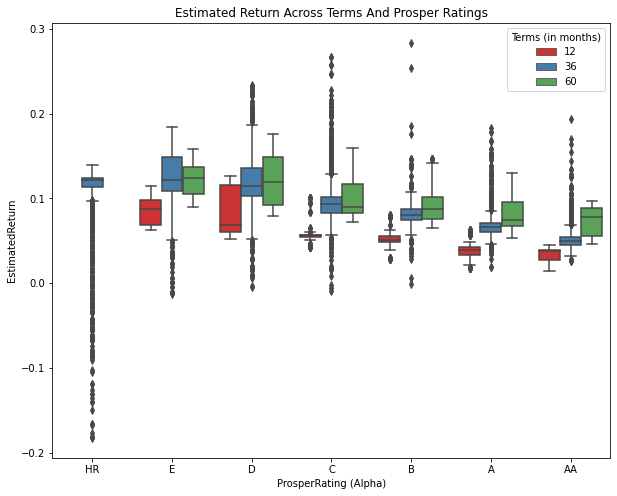

In [ ]:
fig = plt.figure(figsize = [10, 8])
ax = sns.boxplot(x='ProsperRating (Alpha)', y='EstimatedReturn', hue='Term',
                 data=loan_copy, palette="Set1")
plt.title('Estimated Return Across Terms And Prosper Ratings')
plt.legend(title = 'Terms (in months)');

Pair 2: EstimatedReturn vs. Employment Status & Prosper Ratings

####Observations:
    1.   For E & D borrowers, retired workers are seeing higher estimated return vs. unemployed workers.
    2.   C to AA, unemployed workers tend to have the higest rate of return.

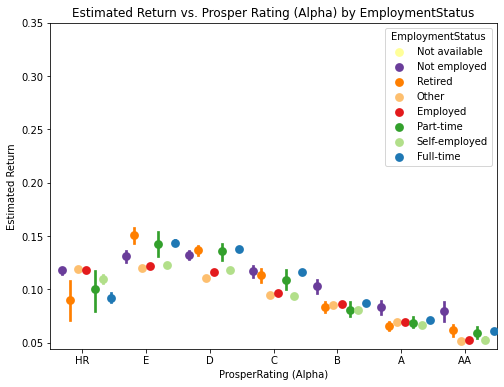

In [ ]:
## Example of nominal data ##
fig = plt.figure(figsize = [8,6])
ax = sns.pointplot(data = loan_copy, x = 'ProsperRating (Alpha)', y = 'EstimatedReturn', hue = 'EmploymentStatus',
           palette = 'Paired_r', linestyles = '', dodge = 0.9)
plt.title('Estimated Return vs. Prosper Rating (Alpha) by EmploymentStatus')
plt.ylabel('Estimated Return')
plt.yticks([0.05,0.10,0.15,0.20,0.25,0.30,0.35], ['0.05','0.10','0.15','0.20','0.25','0.30','0.35'])
ax.set_yticklabels([],minor = True)
plt.show();

Pair 3: EstimatedReturn vs. Income Range & Credit Score



####Observations:
    1.   Across income ranges $25,000 to $100,000+, most of the dark color areas are in a downward trending pattern, meaning that a higher credit score leads to lower estimated returns.
    2.   For lower income ranges however, the pattern is not as obvious and the heatmap is more scattered.

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


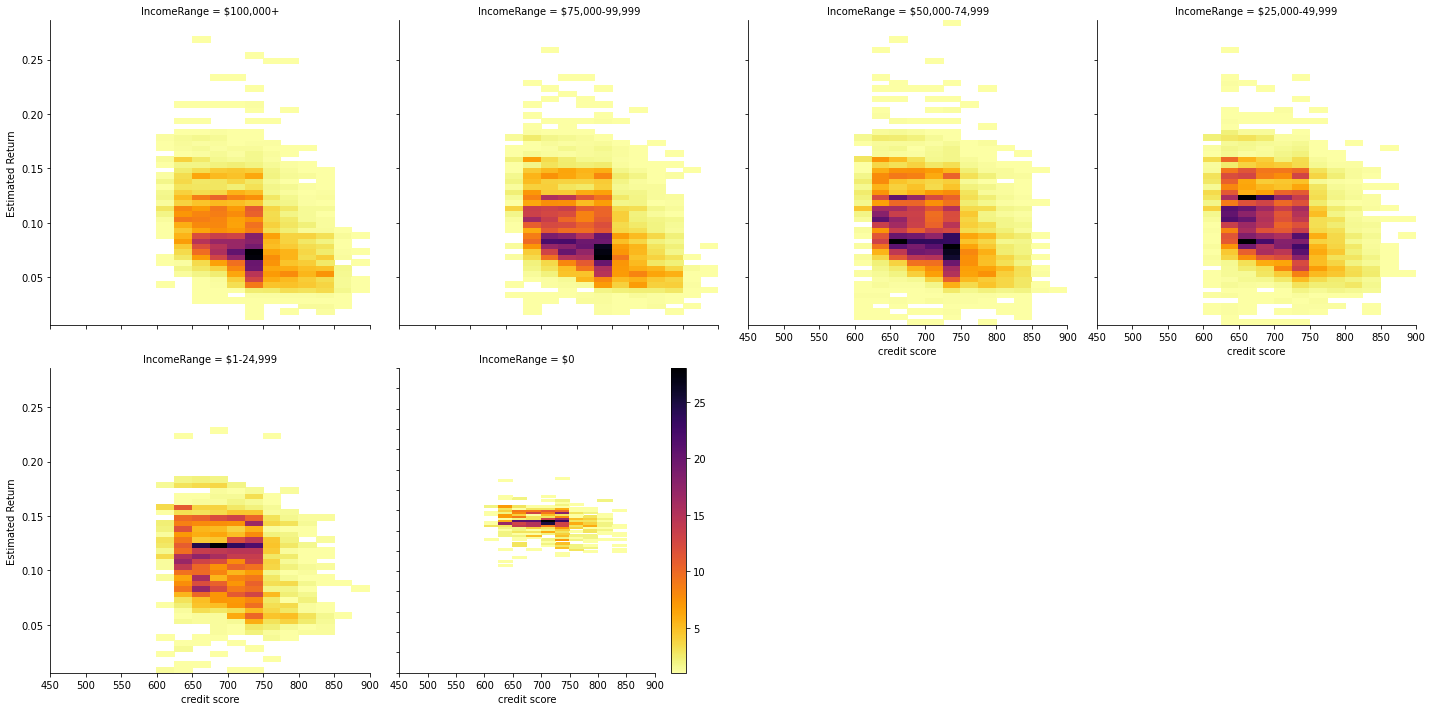

In [ ]:
def hist2dgrid(x, y, **kwargs):
    palette = kwargs.pop('color')
    binsize_x = 25
    bins_x = np.arange(450, loan_copy['average_credit_score'].max()+binsize_x, binsize_x)
    binsize_y = 0.005
    bins_y = np.arange(0.006, loan_copy['EstimatedReturn'].max()+binsize_y, binsize_y)
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 0.5)
    x_ticks = np.arange(450, 900+50, 50)
    x_ticks_names = ['450','500','550','600','650','700','750','800','850','900']
    y_ticks = [-0.25,-0.20,-0.15,-0.10,-0.05,0.0,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50]
    y_ticks_name = ['-0.25','-0.20','-0.15','-0.10','-0.05','0.00','0.05','0.10','0.15','0.20','0.25','0.30','0.35','0.40','0.45','0.50']
    #    y_ticks_names = y_ticks.astype('str')
    plt.xticks(x_ticks,x_ticks_names )
    plt.yticks(y_ticks,y_ticks_name)

# create faceted heat maps on levels of the color variable

g = sns.FacetGrid(data = loan_copy, col = 'IncomeRange', col_wrap = 4, size = 5,
                 xlim = [450, 900], ylim = [-0.30,0.30])
g.map(hist2dgrid, 'average_credit_score', 'EstimatedReturn', color = 'inferno_r')

g.set_xlabels('credit score')
g.set_ylabels('Estimated Return')
plt.colorbar()
plt.show()

###Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?



**Loan Terms**

*   For high-rating borrowers (A or AA), 60-month loans usually have a higher Estimated Return vs. 12-month loans. The longer the loan, the riskier the transaction is for Prosper; more often than not leads to higher returns
*   When it comes to lower credit rating borrowers (E), 36-month loans actually give the highest returns than 60-month ones. 



**Employment Status & Prosper Ratings**

*   For E & D Prosper rating borrowers, retired workers are seeing higher estimated return vs. unemployed workers.
*   However, when it comes to those with C to AA ratings, unemployed workers tend to have the higest rate of return.



**Income Range & Credit Score**

*   Across income ranges 25,000 to 100,000+, most of the dark color areas are in a downward trending pattern, meaning that a higher credit score leads to lower estimated returns.
*   For lower income ranges however, the pattern is not as obvious and the heatmap is more scattered.



###Were there any interesting or surprising interactions between features?



An interesting finding is estimated returns decrease with an increase in term for customers who fall within the with rating HR-C, but for those with prosper ratings B-AA, the estimated returns increases with an increase in term; 60-month loans.

In [46]:
!jupyter nbconvert --to html /Exploration_Loan Data_Prosper_Part1.ipynb

[NbConvertApp] WARNING | pattern '/Exploration_Loan' matched no files
[NbConvertApp] WARNING | pattern 'Data_Prosper_Part1.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead 